#Stochastic Optimization of a Hydropower Chain

Remark: This example requires a full version of the QUASAR stochastic optimizer. Please contact <info@quantego.com> to schedule a demo or obtain a free copy for academic use.

In [1]:
from pyquasar import *

##Import the Lattice
Let us assume that the inflow and price lattice has been created in a separate step. We are simply going to import the lattice which is stored as a CSV and then combine the two lattices into a single joint lattice. The combined lattice is the cross-product of the two lattice.

In [2]:
price_lattice = Lattice.from_csv('assets/price_lattice')
inflow_lattice = Lattice.from_csv('assets/inflow_lattice')
lattice = Lattice.combine(price_lattice,inflow_lattice)
num_days = lattice.num_stages()

### Simulation and Visualization
We can easily draw a sample of scenarios from the lattice and take a look at a few inflow time series as well as the distribution of the annual mean.

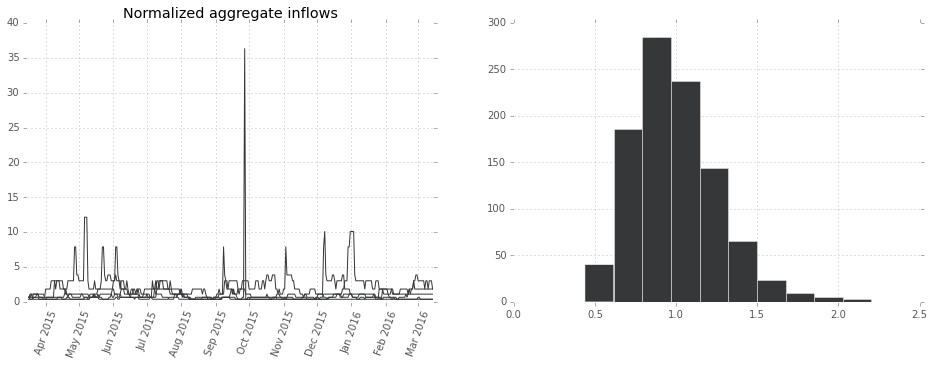

In [3]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(16,5))
inflow_sample = lattice.simulate(num_stages=num_days, sample_size=1000)
inflow_sample.set_time_index(start='2015-03-15',freq='d')
inflow_sample.query('series<5').inflow.spaghetti(
    ax=ax1, xlabel='', title='Normalized aggregate inflows', alpha=1.0)
inflow_sample.inflow.groupby_series.mean().hist(ax=ax2)
plt.show()

##Parameter values
Parameters of the hydro storage system are stored in a nested dictionary where the outer dictionary denotes the reservoirs and the inner dictionaries define the reservoir parameters.

In [4]:
forward_curve = None # (days x hours) matrix to shift the price curve
penaltyCost = 1000
reservoirs = {
        1:{
            "res_max":73000,
            "res_min":22000,
            "res_init":50300,
            "res_goal":{num_days-1:50300},
            "percent_inflow":0.5, #1000m3/h
            "tb_max":46.,
            "tb_flow":7.65,
            "pm_max":18.48,
            "pm_flow":5.51,
            "sink": 2},

       2:{
            "res_max":21000,
            "res_min":17873, 
            "res_init":17873,
            "res_goal":{num_days-1:17873},
            "percent_inflow":0.2,
            "tb_max":15.0,
            "tb_flow":6.38,
            "sink":3},
       3:{
            "res_max":2500,
            "res_min":1700,
            "res_init":1700,
            "res_goal":{num_days-1:1700},
            "percent_inflow":0.3,
            "tb_max":2.65,
            "tb_flow":25.65}}

## Step 4: Model
### Dynamic program
The model is a stochastic-dynamic program which holds a linear program at each stage. 

$$\begin{align} V(S_t,R_t) = \max \ & \sum_{j \in \mathscr{J}} \sum_{h \in \mathscr{H}} p_h(S_t) \left( d_{jh} - c_{jh} \right) + \mathbb{E}[V(S_{t+1},R_{t+1})|S_t] \\ s.t.\ \ & r_{jh} =\ r_{jh-1} - \eta^G_{j}d_{jh} + \eta^P_{j} c_{jh} - s_{jh}+ f(S_t)_{j} + \sum_{k\in\mathscr{J}:A_{kj}=1} (d_{kh}+ s_{kh})-\sum_{k\in\mathscr{J}:A_{jk}=-1}c_{kh} && \forall \ j \in \mathscr{J},h \in \mathscr{H} \\ & r_{j0} =R_{tj}, \ R_{t+1,j}=r_{j24} && \forall \ j \in \mathscr{J} \\ &\operatorname{LB}_j^R \leq r_{jh} \leq \operatorname{UB}_j^R , \ d_{s jh} \leq \operatorname{UB}_j^G, \ c_{jh} \leq \operatorname{UB}_j^P &&\forall \ j \in \mathscr{J},h \in \mathscr{H} ,\\ &r_{jh},c_{jh},d_{jh},s_{jh} \geq 0 && \forall \ j \in \mathscr{J},h \in \mathscr{H}. \end{align}$$
 
###Notation 
$t \in \mathscr{T}$ = days, $h \in \{1,\dots,24\}$ = hours, $j \in \mathscr{J}$ = reservoirs, $S_t$ = environmental state, $A$ = reservoir topology, $p_h(S_t)$ = state-dependent price vector, $f_j(S_t)$ = state-dependent inflow, $\eta^G_{j},\eta^P_{j}$ = water flow per megawatthour, $d_{jh}$ = produced power, $c_{jh}$ = consumed power, $s_{jh}$ = spill, $r_{jh}$ = reservoir content, $\operatorname{LB}_j^R,\operatorname{UB}_j^R$ = reservoir bounds, $\operatorname{UB}_j^G$ = turbine capacity, $\operatorname{UB}_j^P$ = pump capacity


###Implementation
Although the internal and mathematical representation of the model is a dynamic program, it can be formulated just like a linear program. The optimizer will itself take care of the decomposition. We just have to make sure that the resource state variables are bounded and any resource state yields a feasible solution for any given state of the Markov process.

In [5]:
# define a function that holds a model formulation
def hydro_model(reservoirs, num_days, num_hours=24, penalty_cost=1000, forward_shift=None):
    num_res = len(reservoirs)
    model = DecisionProblem()
    res = {i : None for i in reservoirs}
    balance = {i : None for i in reservoirs}
    for t in range(num_days):
        for h in range(num_hours):
            #create balance constraint
            for i in reservoirs:
                par = reservoirs[i]
                next_res = model.addVariable(t, "res_%d_%d"%(i,h))
                balance[i] = (res[i] if t>0 or h>0 else par["res_init"]) + 3.6*par["percent_inflow"]*rand("inflow")
                res[i] = next_res #state transition 
                model += next_res <= par["res_max"]
                model += next_res >= par["res_min"]
            #add flows to balance constraint
            for i in reservoirs:
                par = reservoirs[i]
                turbine,spill = model.addVariables(t, "turbine_%d_%d"%(i,h), "spill_%d_%d"%(i,h))
                balance[i] += -par["tb_flow"]*turbine - spill
                if "sink" in par:
                    balance[par["sink"]] += par["tb_flow"]*turbine + spill
                if "pm_max" in par:
                    pump = model.addVariable(t, "pump_%d_%d"%(i,h))
                    balance[i] += par["pm_flow"]*pump
                    if "sink" in par:
                        balance[par["sink"]] += -par["pm_flow"]*pump
                    model += pump <= par["pm_max"]# define a function that holds a model formulation
                #bounds
                model += turbine <= par["tb_max"] 
                #add flows to objective
                model += rand("price_%d"%h)*(turbine-(pump if "pm_max" in par else 0))
                if forward_shift is not None:
                    model += shift*(turbine-(pump if "pm_max" in par else 0))
                #final penalty
                if "res_goal" in par:
                    goal = step_function(t,par["res_goal"])
                    if goal > 0:
                        shortfall = model.addVariable(t, "shortfall_%d_%d"%(i,h))
                        model += shortfall >= goal-res[i]
                        model += -penalty_cost*shortfall
            #add balance constraint to model
            for i in reservoirs:
                model += res[i] == balance[i]
    return model
#step function used for time-dependent reservoir levels
def step_function(xval, steps):
    y = 0
    for x in sorted(steps):
        if xval>=x:
            y = steps[x]
        else:
            break
    return y
#function to compute the mean shift towards the forward curve
def compute_forward_shift(forward_prices, lattice,num_hours=24, sample_size=1000):
    if forward_prices is None:
        return None
    lat_sample = lat.sample(stages=num_days,sample_size=1000)
    mean_prices = [None]*num_hours
    for i in range(num_hours):
        mean_prices[i] = lat_sample.df['price_%d'%i].mean()
    forward_shift = [[None]*num_hours]*num_days
    for t in range(num_days):
        for i in range(num_hours):
            forward_shift[t][i] = forward_prices[t][i]-mean_prices[i][t]
    return forward_shift

##Calling the optimizer
We now call the function to create an instance of the decision model.

In [6]:
model = hydro_model(reservoirs, num_days,
                    forward_shift=compute_forward_shift(forward_curve, lattice),
                    penalty_cost=penaltyCost)

Model and lattice are then passed into the dynamic optimizer. The optimizer runs inside a separate thread, which gives us the opportunity to check the progress of the optimizer and stop it manually. If we want to execute all commands of our notebook and just wait for it to finish, we can use the <code>join()</code> method which joins the optimizer thread with the main thread.

In [7]:
opt = DynamicOptimizer(model, lattice)
opt.solve()
#opt.join()

###Convergence info
The optimizer has converged when the dual upper bound ,which is given by the value function of the underlying dynamic program, has converged to the expected value of the total rewards, which can be approximated from simulating the current candidate policy. The policy is derived from using the current value function approximation to make decisions. 

Convergence info info can be obtained while the optimizer is running.

,expReward,simReward,stdError,hyperplanes,numSolves,duration
iter,,,,,,
330,1281694.59,-1406101.88,2683596.88,1713781,12045659,1052
331,1281624.62,-1409674.37,2683405.20,1723788,12082161,1055
332,1281622.47,-1401079.57,2683857.25,1723512,12118663,1059
333,1281480.65,-1399100.43,2683960.66,1733076,12155165,1062
334,1281579.76,1247430.62,6596.21,1741946,12191667,1091


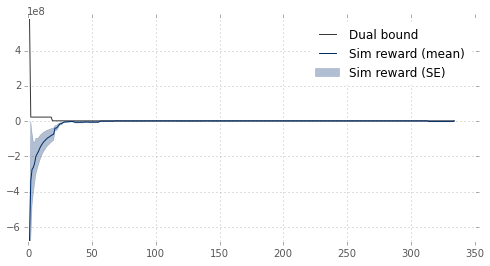

In [8]:
opt.plot()
opt.stats.tail()

Although this optimization problem usually takes only a few minutes, we can also manually stop the optimizer of we do not wait for the automatic convergence check to stop the algorithm.

In [9]:
opt.stop()

##Step 6: Getting the solution
Exact solution information is only given for the sub-problem at the first stage, where prices and inflows a re deterministic. For all subsequent stages only uncertain solution information based on simulation is available.

In [10]:
decisions = opt.policy.first_stage_solution().decisions
for var in sorted(decisions):
    if var.startswith("res_1"):
        print "%s, %.2f"%(var,decisions.get(var))

res_1_0, 50205.99
res_1_1, 50207.10
res_1_10, 50217.15
res_1_11, 50218.26
res_1_12, 50219.38
res_1_13, 50220.50
res_1_14, 50323.44
res_1_15, 50325.00
res_1_16, 50326.56
res_1_17, 50327.68
res_1_18, 49976.89
res_1_19, 49626.11
res_1_2, 50208.22
res_1_20, 49533.55
res_1_21, 49534.66
res_1_22, 49535.78
res_1_23, 49638.72
res_1_3, 50209.34
res_1_4, 50210.45
res_1_5, 50211.57
res_1_6, 50212.68
res_1_7, 50213.80
res_1_8, 50214.92
res_1_9, 50216.03


##Step 7: Simulating the optimal policy
Because getting an exact solution for each scenario is untractable - there are $100^{365}$ possible scenarios - we can analyze the results by looking at a sample of decisions from the optimal policy.

In [11]:
sim = opt.policy.simulate(sample_size = 100)
sim.set_time_index(start='2015-03-15',freq='d')

###Reservoir content curves
The development of the reservoir content over time can be nicely visualized using fancharts which show possible reservoir content states with very likely reservoir states being dark colored and less likely states having a lighter color.

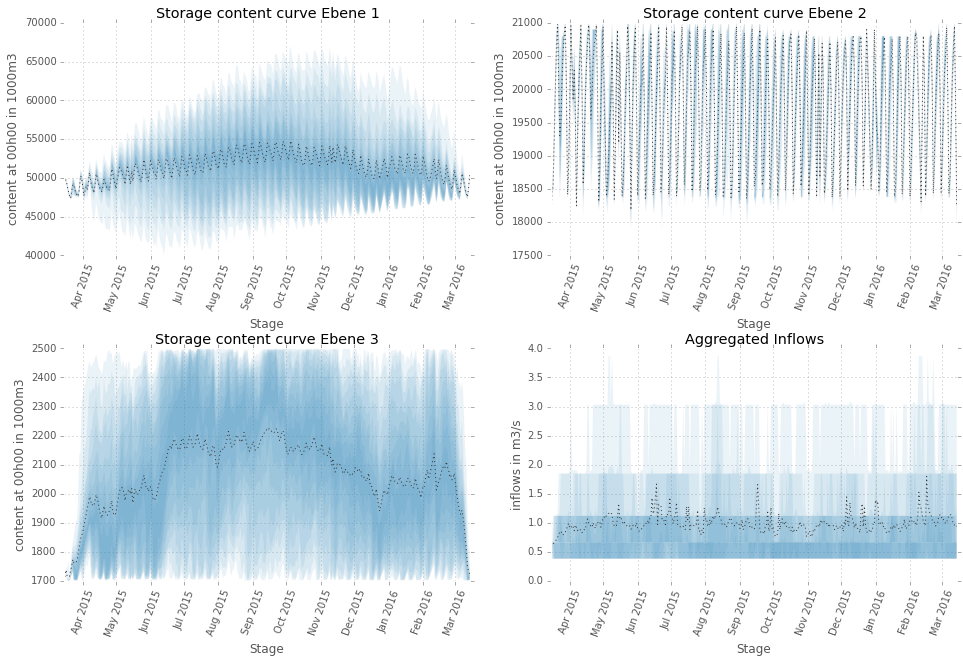

In [12]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16,10))
plt.subplots_adjust(hspace=0.4)
sim.decision['res_1_0'].fanchart(ax1, alpha=0.1)
ax1.set_ylabel('content at 00h00 in 1000m3')
ax1.set_title('Storage content curve Ebene 1')
sim.decision['res_2_0'].fanchart(ax2, alpha=0.1)
ax2.set_ylabel('content at 00h00 in 1000m3')
ax2.set_title('Storage content curve Ebene 2')
sim.decision['res_3_0'].fanchart(ax3, alpha=0.1)
ax3.set_ylabel('content at 00h00 in 1000m3')
ax3.set_title('Storage content curve Ebene 3')
sim.state['inflow'].fanchart(ax4, alpha=0.1)
ax4.set_ylabel('inflows in m3/s')
ax4.set_title('Aggregated Inflows')
plt.show()

###Water values
Each reservoir has a shadow price of the value of water at the end of the day. The realized water values as given by the value function are another useful output from simulating the policy.

In [13]:
for res in reservoirs:
    print "reservoir %d"%res
    groups = sim.shadow_price['res_%d_23'%res].groupby_stage
    for i in pd.date_range(start='2015-03-15',periods=7,freq='d'):
        print i.date(), groups.get_group(i).mean()

reservoir 1
2015-03-15 21.5967686355
2015-03-16 21.5969081681
2015-03-17 21.5972495621
2015-03-18 21.5964408073
2015-03-19 21.5958599544
2015-03-20 21.5963560469
2015-03-21 21.5958675499
reservoir 2
2015-03-15 17.2123867876
2015-03-16 14.7894757326
2015-03-17 14.7206531916
2015-03-18 14.7709951908
2015-03-19 14.8123566872
2015-03-20 15.2656296371
2015-03-21 15.5393767035
reservoir 3
2015-03-15 2.47204689219
2015-03-16 2.46636463323
2015-03-17 2.4690261477
2015-03-18 2.44140147596
2015-03-19 2.37652277157
2015-03-20 2.38251927506
2015-03-21 2.39800887241


###Realized profit
The expected profit as given by the discrete set of scenarios does not necessarily have to correspond to the profits obtained from simulating the policy over the original continuous process. Moreover penalties may occur with the real process that do not happen when the discrete process is used. To learn about the true value of the assets under the given process, the simulated value should be considered.

In [14]:
rewards_df = sim.rewards['rewards']
for i in reservoirs:
     for h in range(24):
        rewards_df += penaltyCost*sim.decision['shortfall_%d_%d'%(i,h)].fillna(0)

In [15]:
rewards_df.groupby_series.sum().quantile([0.05,0.25,0.5,0.75,0.95])

0.05   1071896.49
0.25   1148602.31
0.50   1234893.67
0.75   1328304.23
0.95   1441371.44
dtype: float64